## Dance move prediction using Multilayer Perceptron (MLP) - Approach 2

#### Summary:
- Average accuracy after 5 fold cross validation: 99.6% if using 28k parameters or 98.7% if using only 14k parameters
- Library used: Keras (TensorFlow)
- Dataset from individual dance move is segmented based on the highest data sample series among them and their corresponding label is chosen by mode. The segmented dataset is then reshaped into 3 dimensional array and flattened for MLP training
- No manual feature extraction - MLP trains and extracts features from unprocessed raw data
- <font color=blue>**Average convergence time is around 25 times faster than CNN**</color>

In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.neural_network as nn
import pickle
from glob import glob
from timeit import default_timer as timer
import sys
from GraphingAndTransfer.extractDataset import *
import scipy.stats as stats

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from tune_sklearn import TuneGridSearchCV

from keras.utils import np_utils,to_categorical
from keras.optimizers import RMSprop, Adam
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import optimizers

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
# plt.style.use('bmh')

file_path = "GraphingAndTransfer/processed/*"

pd.set_option("display.max_rows", None, "display.max_columns", None)
np.set_printoptions(threshold=100000) # 'sys.maxsize' for max

### Define segmentation window

In [2]:
NUMBER_OF_AFTER_SAMPLES = 8 #Number of samples to include in dance move after end detected
NUMBER_OF_BEFORE_SAMPLES = 8 #Number of samples to include in dance move before start detected
MINIMUM_MOVE_TIME = 20 #Minimum number of samples to be considered a move. Set this too low and you will get garbage dance samples

In [3]:
danceMoveDataset = processData(NUMBER_OF_AFTER_SAMPLES, NUMBER_OF_BEFORE_SAMPLES, MINIMUM_MOVE_TIME)

Recording from dev2 with move pointhigh at 16152387977925 opened with 685 samples
Recording from dev2 with move hair at 16152385941495 opened with 898 samples
Recording from dev2 with move dab at 16152380133389 opened with 786 samples
Recording from dev2 with move pointhigh at 16152388450418 opened with 188 samples
Recording from dev2 with move listen at 16152386837158 opened with 703 samples
Recording from dev2 with move gun at 16152384604594 opened with 903 samples
Recording from dev2 with move elbowkick at 16152382981181 opened with 1498 samples
Recording from dev2 with move sidepump at 16152389923805 opened with 754 samples
Recording from dev2 with move wipetable at 16152391069694 opened with 881 samples
Done
Extracted 87 moves from 9 raw data Sequences.
10  dab
10  elbowkick
12  gun
11  hair
12  listen
11  pointhigh
10  sidepump
11  wipetable
0  defaultMove


### Visualise each move sample in the segmentation window defined above

In [ ]:
for i in range (1, len(danceMoveDataset)):
    danceMoveDataset[i].plot()

### Number of series of samples in each move, based on the segmentation window defined above.

In [4]:
folder_path = "GraphingAndTransfer/processed/"
noOfSamples = []
for text_file in sorted(os.listdir(folder_path)):
    print("Processing:", text_file)
    
    with open(folder_path+text_file, 'r') as f:
        file = f.readlines()[1:]
    print("Number of series of samples in this move =", np.asarray(file).shape[0], "\n")
    
    noOfSamples.append(np.asarray(file).shape[0])

Processing: dev2_dab_16152380133389_19
Number of series of samples in this move = 38 

Processing: dev2_dab_16152380133389_20
Number of series of samples in this move = 41 

Processing: dev2_dab_16152380133389_21
Number of series of samples in this move = 47 

Processing: dev2_dab_16152380133389_22
Number of series of samples in this move = 53 

Processing: dev2_dab_16152380133389_23
Number of series of samples in this move = 52 

Processing: dev2_dab_16152380133389_24
Number of series of samples in this move = 50 

Processing: dev2_dab_16152380133389_25
Number of series of samples in this move = 37 

Processing: dev2_dab_16152380133389_26
Number of series of samples in this move = 48 

Processing: dev2_dab_16152380133389_27
Number of series of samples in this move = 53 

Processing: dev2_dab_16152380133389_28
Number of series of samples in this move = 52 

Processing: dev2_dab_16152380133389_29
Number of series of samples in this move = 44 

Processing: dev2_elbowkick_16152382981181_5

### Find the minimum and maximum number of samples in all captured moves

In [5]:
min_n_samples = min(noOfSamples)
max_n_samples = max(noOfSamples)
print("Minimum: {} \nMaximum: {}" .format(min_n_samples, max_n_samples))

Minimum: 36 
Maximum: 71


### Selecting only the first 36 series of samples in each move and append in to a dataframe in order

In [6]:
columns = ['acc_X','acc_Y','acc_Z','gyro_X','gyro_Y','gyro_Z','Stage', 'Activity']
combined_raw = pd.DataFrame(columns = columns)

In [7]:
folder_path = "GraphingAndTransfer/processed/"
for text_file in sorted(os.listdir(folder_path)):
    print("Processing:", text_file)
    
    with open(folder_path+text_file, 'r') as f:
        file = f.readlines()[1:]
        
    temp_list = []
    
    for line in file:
        temp_list.append([float(value) for value in line.split(',')])
    
    print("Shape =", np.asarray(temp_list).shape, "\n")

    # file_path_name = os.path.splitext(text_file)[0]
    # activity_labels = file_path_name.split('_')[1]

    activity_labels = text_file.split('_')[1]
        
    raw_data = np.array(temp_list)
        
    df_raw = pd.DataFrame(data = raw_data, columns = ['acc_X','acc_Y','acc_Z','gyro_X','gyro_Y','gyro_Z','Stage'])
    df_raw['Activity'] = activity_labels
    combined_raw = combined_raw.append(df_raw)

combined_raw.reset_index(drop=True, inplace=True)

Processing: dev2_dab_16152380133389_19
Shape = (38, 7) 

Processing: dev2_dab_16152380133389_20
Shape = (41, 7) 

Processing: dev2_dab_16152380133389_21
Shape = (47, 7) 

Processing: dev2_dab_16152380133389_22
Shape = (53, 7) 

Processing: dev2_dab_16152380133389_23
Shape = (52, 7) 

Processing: dev2_dab_16152380133389_24
Shape = (50, 7) 

Processing: dev2_dab_16152380133389_25
Shape = (37, 7) 

Processing: dev2_dab_16152380133389_26
Shape = (48, 7) 

Processing: dev2_dab_16152380133389_27
Shape = (53, 7) 

Processing: dev2_dab_16152380133389_28
Shape = (52, 7) 

Processing: dev2_dab_16152380133389_29
Shape = (44, 7) 

Processing: dev2_elbowkick_16152382981181_56
Shape = (37, 7) 

Processing: dev2_elbowkick_16152382981181_57
Shape = (37, 7) 

Processing: dev2_elbowkick_16152382981181_58
Shape = (40, 7) 

Processing: dev2_elbowkick_16152382981181_59
Shape = (37, 7) 

Processing: dev2_elbowkick_16152382981181_60
Shape = (36, 7) 

Processing: dev2_elbowkick_16152382981181_61
Shape = (36, 

In [ ]:
combined_raw

In [8]:
X = combined_raw.iloc[:,:-2]
y = combined_raw.iloc[:, -1]

In [ ]:
X

### Choose <code>max_n_samples</code>  for segmenting a window

In [ ]:
Fs = 10 # sampling freq
frame_size = max_n_samples
sliding_overlap = Fs*2 # 50% overlap

In [ ]:
def get_frames(df, frame_size, sliding_overlap):

    N_FEATURES = 6 # number of features

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size):
        acc_X = df['acc_X'].values[i: i + frame_size]
        acc_Y = df['acc_Y'].values[i: i + frame_size]
        acc_Z = df['acc_Z'].values[i: i + frame_size]
        gyro_X = df['gyro_X'].values[i: i + frame_size]
        gyro_Y = df['gyro_Y'].values[i: i + frame_size]
        gyro_Z = df['gyro_Z'].values[i: i + frame_size]
        
        # Select the label that appears the most often in this segment
        label = stats.mode(df['Activity'][i: i + frame_size])[0][0]
        frames.append([acc_X, acc_Y, acc_Z, gyro_X, gyro_Y, gyro_Z])
        labels.append(label)

    frames = np.asarray(frames).reshape(-1, N_FEATURES, frame_size)
    labels = np.asarray(labels, dtype=object)

    return frames, labels

In [ ]:
# X, y = get_frames(combined_raw, frame_size, sliding_overlap)

In [9]:
X.shape

(5414, 6)

In [ ]:
X

In [ ]:
y

In [10]:
encoder = preprocessing.LabelEncoder()
encoder.fit(y)
y = encoder.fit_transform(y)

In [ ]:
y

In [11]:
encoder.classes_

array(['dab', 'elbowkick', 'gun', 'hair', 'listen', 'pointhigh',
       'sidepump', 'wipetable'], dtype=object)

### Search for optimal hyperparameters using Tune Search (https://github.com/ray-project/tune-sklearn)

In [ ]:
# Bad: always exceed epoch limit without convergence. To be considered in future.
def tuneSearch():
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=None, shuffle=True)

    mlp_adam = nn.MLPClassifier(solver='adam', early_stopping=True, batch_size=32)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    tune_parameters = {
        'hidden_layer_sizes': [(100,200), (150,200), (200, 150), (50, 200, 3)],
        'activation': ['tanh', 'relu'],
        'solver': ['adam'],
        'alpha': [1e-4, 1e-1, 0.05],
        'epsilon':[0.01, 0.1]
    }
    
    tune_search = TuneGridSearchCV(
        mlp_adam,
        tune_parameters,
        early_stopping=True,
        max_iters=10
    )
    
    tune_search.fit(X_train, y_train)
    pred = tune_search.predict(X_test)
    accuracy = np.count_nonzero(np.array(pred) == np.array(y_test)) / len(pred)
    print("Tune Accuracy:", accuracy)
    print(tune_search.best_params_)

### Search for optimal hyperparameters using GridSearchCV

In [ ]:
def GSCV():
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, shuffle=True)

    mlp_adam = nn.MLPClassifier(solver='adam', early_stopping=True, batch_size=minSamples)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
#     print('X_train:', X_train)
#     print('X_test:', X_test)
#     print('y_train:', y_train)
#     print('y_test:', y_test)

    parameter_space = {
        'hidden_layer_sizes': [(100,200), (150,200), (200, 150), (50,200,3),
                               (50,100,50), (100,), (200,), (300,), (400,)],
        'activation': ['tanh', 'relu'],
        'alpha': [0.0001, 0.001, 0.05],
        'tol': [1e-4, 1e-5, 1e-6]        
    }
    
        
    clf = GridSearchCV(mlp_adam, parameter_space, scoring='accuracy', n_jobs=-1, cv=3, verbose=3)
    clf.fit(X_train, y_train)
        
    print('Best parameters found:\n', clf.best_params_)

#     # All results
#     means = clf.cv_results_['mean_test_score']
#     stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        
    mlp_pred = clf.predict(X_test)
    
    print('Results on the test set:')
    print(classification_report(y_test, mlp_pred, target_names=encoder.classes_))

In [ ]:
GSCV()

#### Note the optimal hyperparameters found above are just indicative

## MLP Training

In [12]:
train_histories = []
cm_hist = []
classification_report_hist = []

In [17]:
def perform_mlp(fold, pca):
    start_time = timer()
    k = fold
    perform_pca = pca
    kf = KFold(n_splits=k, shuffle=True)
    #kf = StratifiedKFold(n_splits=k, shuffle=True)

    
# # Trial 3: ave accuracy 81%
#     mlp_adam = nn.MLPClassifier(hidden_layer_sizes=(200, 150), max_iter=500, activation='tanh', solver='adam',
#                                       batch_size = minSamples, validation_fraction=0.2, n_iter_no_change=20,
#                                       alpha=1e-4, early_stopping=True, verbose=0, tol=1e-6, random_state=None, 
#                                       learning_rate_init=0.001, shuffle=False) 

    acc_scores = []
    cv_iteration = 1
    cv_pca_iteration = 1
    train_histories.clear()
    cm_hist.clear()
    classification_report_hist.clear()
#     train_histories_mlp_sgd.clear()
#     train_histories_mlp_adam.clear()
    
    for train_index, test_index in kf.split(X):
        
        if perform_pca == False:
            print('\nTraining model and cross validate using fold #{}...\n ' .format(cv_iteration))
            cv_iteration += 1
        
#         X_train , X_test = X[train_index,:], X[test_index,:]
        X_train , X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train , y_test = y[train_index], y[test_index]
        
#         X_train , X_test = X[train_index,:], X[test_index,:]
#  
        
#         print('X_train shape:', X_train.shape)
#         print('X_test shape:', X_test.shape)

        y_test_without_transform = y_test

#         print('X_train before standard scaler: ', X_train)
#         print('X_test before standard scaler: ', X_test)        
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
#         scaler = StandardScaler()
#         X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
#         X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
        
        
#         print('X_train shape:', X_train.shape)
#         print('X_test shape:', X_test.shape)        

        
        y_train = to_categorical(y_train, num_classes=8)
        y_test = to_categorical(y_test, num_classes=8)
        
        
        
        
        
#         X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
#         X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)     
        
        
        
        
        
#         print('X_train shape:', X_train.shape)
#         print('X_test shape:', X_test.shape)
        
        if perform_pca == True:
            print('\nTraining model with PCA and cross validate using fold #{}...\n ' .format(cv_pca_iteration))
            cv_pca_iteration += 1
            pca = PCA(n_components = 4) # n=100 is the usual consensus in HAR
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
            pca.explained_variance_ratio_

        def mlp_model():
            model = Sequential()
#             model.add(Flatten(input_shape=X_train[0].shape))
#             model.add(Dropout(0.2))
            model.add(Dense(units=128, kernel_initializer='random_uniform', activation='relu', input_shape=X_train[0].shape))
    #             model.add(Dense(units=64, kernel_initializer='uniform', activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(units=128, kernel_initializer='uniform', activation='relu'))
#             model.add(Flatten())
            model.add(Dense(units=64, kernel_initializer='uniform', activation='relu'))
#             model.add(Dropout(0.2))
            model.add(Dense(units=8, kernel_initializer='uniform', activation='softmax'))
            model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
            return model
        
        mlp = mlp_model()
        print(mlp.summary())        
        
        checkpoint_filepath="checkpoint/Approach 3/MLP_weights_checkpoint.hdf5"
                
        my_callbacks = [
            EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20),
            ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.00001, patience=20, verbose=1),
            ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only=True, monitor='val_accuracy',
                            verbose=1, save_best_only=True, mode='max')  
        ] 
        
        history = mlp.fit(X_train, y_train, batch_size=64, epochs=200, validation_data=(X_test, y_test),
                                  callbacks=[my_callbacks])
        
        mlp_pred = np.argmax(mlp.predict(X_test), axis=-1)
        scores = mlp.evaluate(X_test, y_test, batch_size=64, verbose=0)
        acc_scores.append(scores[1])
        train_histories.append(history.history)
        
        mlp_weights = mlp.get_weights()
        print("MLP Weights:", mlp_weights)
        
        mlp.save('saved_models/Approach 3/MLP_weights')
        
        print('y_test\n', y_test_without_transform)
        print('')
        print('mlp_pred\n', mlp_pred)
        
        cm_hist.append(confusion_matrix(y_test_without_transform, mlp_pred))
        classification_report_hist.append(classification_report(y_test_without_transform, mlp_pred, target_names=encoder.classes_))
        

    end_time = timer()
    time_taken = end_time - start_time

    return acc_scores, time_taken

In [18]:
acc_scores, time_taken = perform_mlp(fold=5, pca=False)


Training model and cross validate using fold #1...
 
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               896       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 520       
Total params: 26,184
Trainable params: 26,184
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
68/68 [==============================] - 1s 3

68/68 [==============================] - 0s 2ms/step - loss: 0.7862 - accuracy: 0.6953 - val_loss: 0.7650 - val_accuracy: 0.7295

Epoch 00031: val_accuracy improved from 0.72114 to 0.72946, saving model to checkpoint/Approach 3/MLP_weights_checkpoint.hdf5
Epoch 32/200
68/68 [==============================] - 0s 2ms/step - loss: 0.7872 - accuracy: 0.7067 - val_loss: 0.7491 - val_accuracy: 0.7368

Epoch 00032: val_accuracy improved from 0.72946 to 0.73684, saving model to checkpoint/Approach 3/MLP_weights_checkpoint.hdf5
Epoch 33/200
68/68 [==============================] - 0s 2ms/step - loss: 0.7694 - accuracy: 0.7128 - val_loss: 0.7575 - val_accuracy: 0.7230

Epoch 00033: val_accuracy did not improve from 0.73684
Epoch 34/200
68/68 [==============================] - 0s 2ms/step - loss: 0.7755 - accuracy: 0.7045 - val_loss: 0.7546 - val_accuracy: 0.7258

Epoch 00034: val_accuracy did not improve from 0.73684
Epoch 35/200
68/68 [==============================] - 0s 2ms/step - loss: 0.760

68/68 [==============================] - 0s 2ms/step - loss: 0.6385 - accuracy: 0.7571 - val_loss: 0.6573 - val_accuracy: 0.7572

Epoch 00070: val_accuracy did not improve from 0.76270
Epoch 71/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6213 - accuracy: 0.7606 - val_loss: 0.6620 - val_accuracy: 0.7525

Epoch 00071: val_accuracy did not improve from 0.76270
Epoch 72/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6200 - accuracy: 0.7624 - val_loss: 0.6592 - val_accuracy: 0.7562

Epoch 00072: val_accuracy did not improve from 0.76270
Epoch 73/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6177 - accuracy: 0.7613 - val_loss: 0.6616 - val_accuracy: 0.7608

Epoch 00073: val_accuracy did not improve from 0.76270
Epoch 74/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6311 - accuracy: 0.7588 - val_loss: 0.6442 - val_accuracy: 0.7627

Epoch 00074: val_accuracy did not improve from 0.76270
Epoch 75/200
68/68 [===

68/68 [==============================] - 0s 2ms/step - loss: 0.5458 - accuracy: 0.7840 - val_loss: 0.6410 - val_accuracy: 0.7719

Epoch 00110: val_accuracy did not improve from 0.78301
Epoch 111/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5564 - accuracy: 0.7758 - val_loss: 0.6252 - val_accuracy: 0.7738

Epoch 00111: val_accuracy did not improve from 0.78301
Epoch 112/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5733 - accuracy: 0.7722 - val_loss: 0.6454 - val_accuracy: 0.7719

Epoch 00112: val_accuracy did not improve from 0.78301
Epoch 113/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5443 - accuracy: 0.7885 - val_loss: 0.6256 - val_accuracy: 0.7793

Epoch 00113: val_accuracy did not improve from 0.78301
Epoch 114/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5466 - accuracy: 0.7884 - val_loss: 0.6245 - val_accuracy: 0.7839

Epoch 00114: val_accuracy improved from 0.78301 to 0.78393, saving model t

68/68 [==============================] - 0s 2ms/step - loss: 0.5278 - accuracy: 0.8019 - val_loss: 0.6241 - val_accuracy: 0.7932

Epoch 00149: val_accuracy did not improve from 0.79594
Epoch 00149: early stopping
MLP Weights: [array([[-2.93804675e-01,  2.26397365e-01, -2.16937035e-01,
         1.96767285e-01,  5.17942250e-01, -3.71114522e-01,
         1.04946569e-01,  6.25193715e-02, -1.05199777e-01,
        -4.97485250e-02,  1.35682765e-02, -1.09929301e-01,
         2.79747277e-01,  1.96629047e-01, -2.63442129e-01,
         3.79937738e-01,  3.54596466e-01,  1.00481920e-01,
        -2.82702595e-01, -6.28247187e-02,  4.91896830e-02,
        -1.98887035e-01,  2.16202378e-01,  1.62652619e-02,
        -3.24243426e-01,  1.06720440e-01, -4.83424515e-02,
         2.08366930e-01,  1.70470759e-01, -1.15679301e-01,
        -5.10485470e-01, -3.84159535e-02,  1.16808392e-01,
         1.32786974e-01,  8.88435766e-02,  1.75942611e-02,
         3.71218562e-01, -1.01702921e-02, -1.90542907e-01,
      

INFO:tensorflow:Assets written to: saved_models/Approach 3/MLP_weights/assets
y_test
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4

68/68 [==============================] - 0s 2ms/step - loss: 0.9765 - accuracy: 0.6200 - val_loss: 0.9872 - val_accuracy: 0.6390

Epoch 00011: val_accuracy did not improve from 0.65651
Epoch 12/200
68/68 [==============================] - 0s 2ms/step - loss: 0.9608 - accuracy: 0.6325 - val_loss: 0.9536 - val_accuracy: 0.6362

Epoch 00012: val_accuracy did not improve from 0.65651
Epoch 13/200
68/68 [==============================] - 0s 2ms/step - loss: 0.9456 - accuracy: 0.6399 - val_loss: 0.9496 - val_accuracy: 0.6519

Epoch 00013: val_accuracy did not improve from 0.65651
Epoch 14/200
68/68 [==============================] - 0s 2ms/step - loss: 0.9214 - accuracy: 0.6559 - val_loss: 0.9185 - val_accuracy: 0.6584

Epoch 00014: val_accuracy improved from 0.65651 to 0.65836, saving model to checkpoint/Approach 3/MLP_weights_checkpoint.hdf5
Epoch 15/200
68/68 [==============================] - 0s 2ms/step - loss: 0.9260 - accuracy: 0.6472 - val_loss: 0.9251 - val_accuracy: 0.6556

Epoch 0

68/68 [==============================] - 0s 2ms/step - loss: 0.7088 - accuracy: 0.7306 - val_loss: 0.7538 - val_accuracy: 0.7184

Epoch 00048: val_accuracy did not improve from 0.72853
Epoch 49/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6959 - accuracy: 0.7366 - val_loss: 0.7543 - val_accuracy: 0.7350

Epoch 00049: val_accuracy improved from 0.72853 to 0.73500, saving model to checkpoint/Approach 3/MLP_weights_checkpoint.hdf5
Epoch 50/200
68/68 [==============================] - 0s 2ms/step - loss: 0.7092 - accuracy: 0.7262 - val_loss: 0.7559 - val_accuracy: 0.7322

Epoch 00050: val_accuracy did not improve from 0.73500
Epoch 51/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.7334 - val_loss: 0.7626 - val_accuracy: 0.7202

Epoch 00051: val_accuracy did not improve from 0.73500
Epoch 52/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6954 - accuracy: 0.7363 - val_loss: 0.7620 - val_accuracy: 0.7221

Epoch 0

68/68 [==============================] - 0s 2ms/step - loss: 0.6094 - accuracy: 0.7637 - val_loss: 0.6733 - val_accuracy: 0.7553

Epoch 00087: val_accuracy did not improve from 0.75993
Epoch 88/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6040 - accuracy: 0.7664 - val_loss: 0.6877 - val_accuracy: 0.7516

Epoch 00088: val_accuracy did not improve from 0.75993
Epoch 89/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5981 - accuracy: 0.7676 - val_loss: 0.6834 - val_accuracy: 0.7562

Epoch 00089: val_accuracy did not improve from 0.75993
Epoch 90/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5921 - accuracy: 0.7755 - val_loss: 0.6773 - val_accuracy: 0.7562

Epoch 00090: val_accuracy did not improve from 0.75993
Epoch 91/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6102 - accuracy: 0.7619 - val_loss: 0.6834 - val_accuracy: 0.7581

Epoch 00091: val_accuracy did not improve from 0.75993
Epoch 92/200
68/68 [===


Epoch 00126: val_accuracy did not improve from 0.77747
Epoch 127/200
68/68 [==============================] - ETA: 0s - loss: 0.5477 - accuracy: 0.79 - 0s 2ms/step - loss: 0.5480 - accuracy: 0.7942 - val_loss: 0.6866 - val_accuracy: 0.7664

Epoch 00127: val_accuracy did not improve from 0.77747
Epoch 128/200
68/68 [==============================] - 0s 1ms/step - loss: 0.5602 - accuracy: 0.7792 - val_loss: 0.6653 - val_accuracy: 0.7608

Epoch 00128: val_accuracy did not improve from 0.77747
Epoch 129/200
68/68 [==============================] - 0s 1ms/step - loss: 0.5524 - accuracy: 0.7831 - val_loss: 0.6967 - val_accuracy: 0.7599

Epoch 00129: val_accuracy did not improve from 0.77747
Epoch 130/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5041 - accuracy: 0.8092 - val_loss: 0.6714 - val_accuracy: 0.7655

Epoch 00130: val_accuracy did not improve from 0.77747
Epoch 131/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5313 - accuracy: 0.7939 - val

INFO:tensorflow:Assets written to: saved_models/Approach 3/MLP_weights/assets
y_test
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4

68/68 [==============================] - 0s 2ms/step - loss: 1.0131 - accuracy: 0.6145 - val_loss: 0.9965 - val_accuracy: 0.6076

Epoch 00011: val_accuracy did not improve from 0.61311
Epoch 12/200
68/68 [==============================] - 0s 2ms/step - loss: 0.9615 - accuracy: 0.6434 - val_loss: 0.9968 - val_accuracy: 0.6307

Epoch 00012: val_accuracy improved from 0.61311 to 0.63066, saving model to checkpoint/Approach 3/MLP_weights_checkpoint.hdf5
Epoch 13/200
68/68 [==============================] - 0s 2ms/step - loss: 0.9787 - accuracy: 0.6272 - val_loss: 0.9715 - val_accuracy: 0.6371

Epoch 00013: val_accuracy improved from 0.63066 to 0.63712, saving model to checkpoint/Approach 3/MLP_weights_checkpoint.hdf5
Epoch 14/200
68/68 [==============================] - 0s 2ms/step - loss: 0.9597 - accuracy: 0.6519 - val_loss: 0.9471 - val_accuracy: 0.6491

Epoch 00014: val_accuracy improved from 0.63712 to 0.64912, saving model to checkpoint/Approach 3/MLP_weights_checkpoint.hdf5
Epoch 15

68/68 [==============================] - 0s 2ms/step - loss: 0.7001 - accuracy: 0.7314 - val_loss: 0.7433 - val_accuracy: 0.7054

Epoch 00048: val_accuracy did not improve from 0.71376
Epoch 49/200
68/68 [==============================] - 0s 2ms/step - loss: 0.7019 - accuracy: 0.7283 - val_loss: 0.7476 - val_accuracy: 0.7082

Epoch 00049: val_accuracy did not improve from 0.71376
Epoch 50/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6948 - accuracy: 0.7356 - val_loss: 0.7481 - val_accuracy: 0.7193

Epoch 00050: val_accuracy improved from 0.71376 to 0.71930, saving model to checkpoint/Approach 3/MLP_weights_checkpoint.hdf5
Epoch 51/200
68/68 [==============================] - 0s 2ms/step - loss: 0.7042 - accuracy: 0.7280 - val_loss: 0.7665 - val_accuracy: 0.7045

Epoch 00051: val_accuracy did not improve from 0.71930
Epoch 52/200
68/68 [==============================] - 0s 2ms/step - loss: 0.7266 - accuracy: 0.7181 - val_loss: 0.7705 - val_accuracy: 0.7110

Epoch 0

68/68 [==============================] - 0s 2ms/step - loss: 0.5872 - accuracy: 0.7720 - val_loss: 0.7066 - val_accuracy: 0.7368

Epoch 00086: val_accuracy did not improve from 0.74792
Epoch 87/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5883 - accuracy: 0.7771 - val_loss: 0.6854 - val_accuracy: 0.7396

Epoch 00087: val_accuracy did not improve from 0.74792
Epoch 88/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6111 - accuracy: 0.7716 - val_loss: 0.7019 - val_accuracy: 0.7359

Epoch 00088: val_accuracy did not improve from 0.74792
Epoch 89/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5879 - accuracy: 0.7722 - val_loss: 0.6865 - val_accuracy: 0.7424

Epoch 00089: val_accuracy did not improve from 0.74792
Epoch 90/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5908 - accuracy: 0.7736 - val_loss: 0.6879 - val_accuracy: 0.7424

Epoch 00090: val_accuracy did not improve from 0.74792
Epoch 91/200
68/68 [===

68/68 [==============================] - 0s 2ms/step - loss: 0.5279 - accuracy: 0.8017 - val_loss: 0.6885 - val_accuracy: 0.7553

Epoch 00125: val_accuracy did not improve from 0.76731
Epoch 126/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5555 - accuracy: 0.7831 - val_loss: 0.6776 - val_accuracy: 0.7498

Epoch 00126: val_accuracy did not improve from 0.76731
Epoch 127/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5405 - accuracy: 0.7990 - val_loss: 0.7000 - val_accuracy: 0.7507

Epoch 00127: val_accuracy did not improve from 0.76731
Epoch 128/200
68/68 [==============================] - 0s 1ms/step - loss: 0.5074 - accuracy: 0.8122 - val_loss: 0.6747 - val_accuracy: 0.7479

Epoch 00128: val_accuracy did not improve from 0.76731
Epoch 129/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5061 - accuracy: 0.8134 - val_loss: 0.6648 - val_accuracy: 0.7535

Epoch 00129: val_accuracy did not improve from 0.76731
Epoch 130/200
68/68

68/68 [==============================] - 0s 2ms/step - loss: 0.4688 - accuracy: 0.8235 - val_loss: 0.6688 - val_accuracy: 0.7645

Epoch 00165: val_accuracy did not improve from 0.77747
Epoch 166/200
68/68 [==============================] - 0s 2ms/step - loss: 0.4844 - accuracy: 0.8206 - val_loss: 0.6819 - val_accuracy: 0.7729

Epoch 00166: val_accuracy did not improve from 0.77747
Epoch 167/200
68/68 [==============================] - 0s 2ms/step - loss: 0.4624 - accuracy: 0.8285 - val_loss: 0.6639 - val_accuracy: 0.7701

Epoch 00167: val_accuracy did not improve from 0.77747
Epoch 168/200
68/68 [==============================] - 0s 2ms/step - loss: 0.4984 - accuracy: 0.8167 - val_loss: 0.6685 - val_accuracy: 0.7572

Epoch 00168: val_accuracy did not improve from 0.77747
Epoch 169/200
68/68 [==============================] - 0s 2ms/step - loss: 0.4881 - accuracy: 0.8180 - val_loss: 0.6626 - val_accuracy: 0.7682

Epoch 00169: val_accuracy did not improve from 0.77747
Epoch 170/200
68/68

INFO:tensorflow:Assets written to: saved_models/Approach 3/MLP_weights/assets
y_test
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4

68/68 [==============================] - 0s 2ms/step - loss: 0.9815 - accuracy: 0.6417 - val_loss: 0.9881 - val_accuracy: 0.6251

Epoch 00011: val_accuracy improved from 0.62235 to 0.62512, saving model to checkpoint/Approach 3/MLP_weights_checkpoint.hdf5
Epoch 12/200
68/68 [==============================] - 0s 2ms/step - loss: 0.9842 - accuracy: 0.6334 - val_loss: 0.9582 - val_accuracy: 0.6464

Epoch 00012: val_accuracy improved from 0.62512 to 0.64635, saving model to checkpoint/Approach 3/MLP_weights_checkpoint.hdf5
Epoch 13/200
68/68 [==============================] - 0s 2ms/step - loss: 0.9471 - accuracy: 0.6469 - val_loss: 0.9416 - val_accuracy: 0.6390

Epoch 00013: val_accuracy did not improve from 0.64635
Epoch 14/200
68/68 [==============================] - 0s 2ms/step - loss: 0.9667 - accuracy: 0.6443 - val_loss: 0.9405 - val_accuracy: 0.6427

Epoch 00014: val_accuracy did not improve from 0.64635
Epoch 15/200
68/68 [==============================] - 0s 2ms/step - loss: 0.923

68/68 [==============================] - 0s 2ms/step - loss: 0.7052 - accuracy: 0.7234 - val_loss: 0.7223 - val_accuracy: 0.7276

Epoch 00046: val_accuracy improved from 0.72022 to 0.72761, saving model to checkpoint/Approach 3/MLP_weights_checkpoint.hdf5
Epoch 47/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.7336 - val_loss: 0.7332 - val_accuracy: 0.7202

Epoch 00047: val_accuracy did not improve from 0.72761
Epoch 48/200
68/68 [==============================] - 0s 2ms/step - loss: 0.7121 - accuracy: 0.7348 - val_loss: 0.7187 - val_accuracy: 0.7193

Epoch 00048: val_accuracy did not improve from 0.72761
Epoch 49/200
68/68 [==============================] - 0s 2ms/step - loss: 0.7022 - accuracy: 0.7363 - val_loss: 0.7286 - val_accuracy: 0.7082

Epoch 00049: val_accuracy did not improve from 0.72761
Epoch 50/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6714 - accuracy: 0.7453 - val_loss: 0.7247 - val_accuracy: 0.7165

Epoch 0


Epoch 00084: val_accuracy did not improve from 0.74977
Epoch 85/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6036 - accuracy: 0.7649 - val_loss: 0.6732 - val_accuracy: 0.7525

Epoch 00085: val_accuracy improved from 0.74977 to 0.75254, saving model to checkpoint/Approach 3/MLP_weights_checkpoint.hdf5
Epoch 86/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6195 - accuracy: 0.7655 - val_loss: 0.6718 - val_accuracy: 0.7488

Epoch 00086: val_accuracy did not improve from 0.75254
Epoch 87/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5993 - accuracy: 0.7730 - val_loss: 0.6642 - val_accuracy: 0.7433

Epoch 00087: val_accuracy did not improve from 0.75254
Epoch 88/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5821 - accuracy: 0.7825 - val_loss: 0.6732 - val_accuracy: 0.7433

Epoch 00088: val_accuracy did not improve from 0.75254
Epoch 89/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5869 

68/68 [==============================] - 0s 2ms/step - loss: 0.5477 - accuracy: 0.7998 - val_loss: 0.6337 - val_accuracy: 0.7664

Epoch 00124: val_accuracy did not improve from 0.77655
Epoch 125/200
68/68 [==============================] - 0s 1ms/step - loss: 0.5328 - accuracy: 0.8050 - val_loss: 0.6366 - val_accuracy: 0.7673

Epoch 00125: val_accuracy did not improve from 0.77655
Epoch 126/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5472 - accuracy: 0.7922 - val_loss: 0.6582 - val_accuracy: 0.7516

Epoch 00126: val_accuracy did not improve from 0.77655
Epoch 127/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5502 - accuracy: 0.7968 - val_loss: 0.6347 - val_accuracy: 0.7655

Epoch 00127: val_accuracy did not improve from 0.77655
Epoch 128/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5407 - accuracy: 0.7971 - val_loss: 0.6216 - val_accuracy: 0.7701

Epoch 00128: val_accuracy did not improve from 0.77655
Epoch 129/200
68/68

68/68 [==============================] - 0s 2ms/step - loss: 0.4778 - accuracy: 0.8211 - val_loss: 0.6012 - val_accuracy: 0.7812

Epoch 00164: val_accuracy did not improve from 0.78393
Epoch 165/200
68/68 [==============================] - 0s 2ms/step - loss: 0.4841 - accuracy: 0.8239 - val_loss: 0.6128 - val_accuracy: 0.7830

Epoch 00165: val_accuracy did not improve from 0.78393
Epoch 166/200
68/68 [==============================] - 0s 2ms/step - loss: 0.4832 - accuracy: 0.8134 - val_loss: 0.6080 - val_accuracy: 0.7775

Epoch 00166: val_accuracy did not improve from 0.78393
Epoch 167/200
68/68 [==============================] - 0s 2ms/step - loss: 0.4714 - accuracy: 0.8181 - val_loss: 0.6204 - val_accuracy: 0.7784

Epoch 00167: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00167: val_accuracy did not improve from 0.78393
Epoch 168/200
68/68 [==============================] - 0s 2ms/step - loss: 0.4723 - accuracy: 0.8256 - val_loss: 0.6000 - val_accuracy: 

INFO:tensorflow:Assets written to: saved_models/Approach 3/MLP_weights/assets
y_test
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4

Epoch 11/200
68/68 [==============================] - 0s 2ms/step - loss: 0.9883 - accuracy: 0.6386 - val_loss: 0.9627 - val_accuracy: 0.6414

Epoch 00011: val_accuracy did not improve from 0.64325
Epoch 12/200
68/68 [==============================] - 0s 2ms/step - loss: 0.9916 - accuracy: 0.6279 - val_loss: 0.9369 - val_accuracy: 0.6442

Epoch 00012: val_accuracy improved from 0.64325 to 0.64418, saving model to checkpoint/Approach 3/MLP_weights_checkpoint.hdf5
Epoch 13/200
68/68 [==============================] - 0s 2ms/step - loss: 0.9620 - accuracy: 0.6271 - val_loss: 0.9284 - val_accuracy: 0.6590

Epoch 00013: val_accuracy improved from 0.64418 to 0.65896, saving model to checkpoint/Approach 3/MLP_weights_checkpoint.hdf5
Epoch 14/200
68/68 [==============================] - 0s 2ms/step - loss: 0.9544 - accuracy: 0.6453 - val_loss: 0.9279 - val_accuracy: 0.6386

Epoch 00014: val_accuracy did not improve from 0.65896
Epoch 15/200
68/68 [==============================] - 0s 2ms/step 

68/68 [==============================] - 0s 2ms/step - loss: 0.6984 - accuracy: 0.7334 - val_loss: 0.7156 - val_accuracy: 0.7255

Epoch 00047: val_accuracy did not improve from 0.72828
Epoch 48/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6849 - accuracy: 0.7311 - val_loss: 0.7077 - val_accuracy: 0.7366

Epoch 00048: val_accuracy improved from 0.72828 to 0.73660, saving model to checkpoint/Approach 3/MLP_weights_checkpoint.hdf5
Epoch 49/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6774 - accuracy: 0.7359 - val_loss: 0.7077 - val_accuracy: 0.7311

Epoch 00049: val_accuracy did not improve from 0.73660
Epoch 50/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6737 - accuracy: 0.7499 - val_loss: 0.7275 - val_accuracy: 0.7274

Epoch 00050: val_accuracy did not improve from 0.73660
Epoch 51/200
68/68 [==============================] - 0s 2ms/step - loss: 0.7073 - accuracy: 0.7192 - val_loss: 0.7242 - val_accuracy: 0.7255

Epoch 0


Epoch 00086: val_accuracy did not improve from 0.76710
Epoch 87/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5759 - accuracy: 0.7781 - val_loss: 0.6789 - val_accuracy: 0.7458

Epoch 00087: val_accuracy did not improve from 0.76710
Epoch 88/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6231 - accuracy: 0.7548 - val_loss: 0.6640 - val_accuracy: 0.7597

Epoch 00088: val_accuracy did not improve from 0.76710
Epoch 89/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6027 - accuracy: 0.7766 - val_loss: 0.6747 - val_accuracy: 0.7505

Epoch 00089: val_accuracy did not improve from 0.76710
Epoch 90/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5669 - accuracy: 0.7780 - val_loss: 0.6549 - val_accuracy: 0.7606

Epoch 00090: val_accuracy did not improve from 0.76710
Epoch 91/200
68/68 [==============================] - 0s 2ms/step - loss: 0.5864 - accuracy: 0.7808 - val_loss: 0.6571 - val_accuracy: 0.7421

Epoch 000

INFO:tensorflow:Assets written to: saved_models/Approach 3/MLP_weights/assets
y_test
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4

In [19]:
print('MLP ADAM - prediction accuracy of each fold:\n {}'.format(acc_scores))
print('')
print('MLP ADAM - average accuracy in 5-fold = {} with std. deviation {}' .format(np.mean(acc_scores), np.std(acc_scores)))
print('')
print('Time taken: {:.2f} seconds' .format(time_taken))

MLP ADAM - prediction accuracy of each fold:
 [0.7931671142578125, 0.7802400588989258, 0.7700831294059753, 0.7940905094146729, 0.7569316029548645]

MLP ADAM - average accuracy in 5-fold = 0.7789024829864502 with std. deviation 0.014116979339460108

Time taken: 101.88 seconds


### Confusion Matrix of each training fold

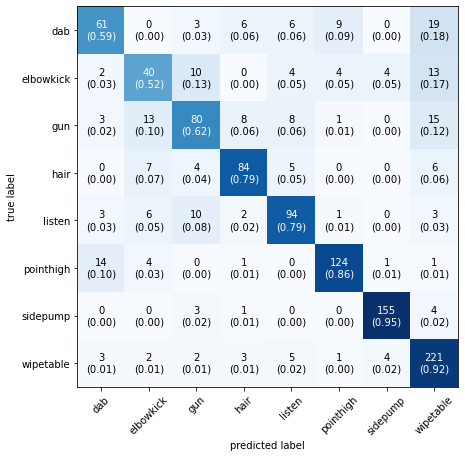

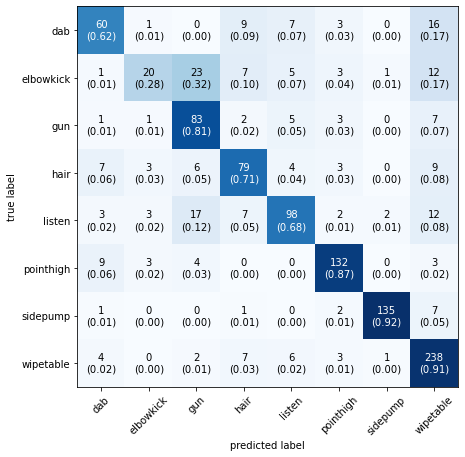

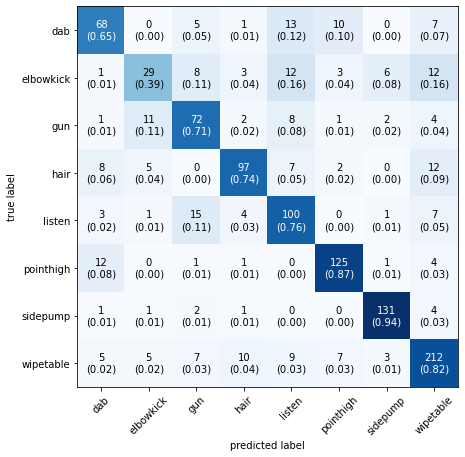

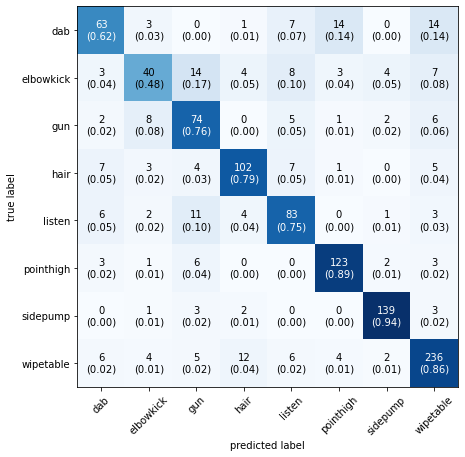

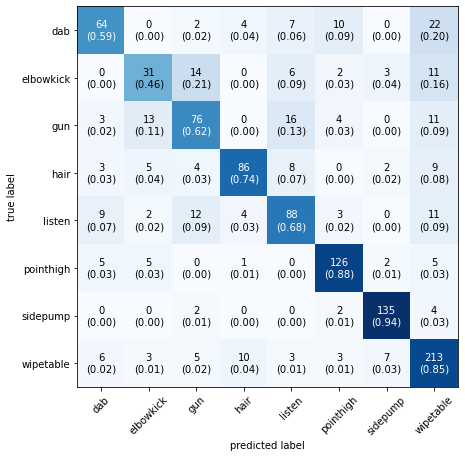

In [20]:
for i in range(5):
    plot_confusion_matrix(conf_mat=cm_hist[i], class_names=encoder.classes_, show_normed=True, 
                          figsize=(7,7), hide_spines=False)

### Classification Report of each training fold

In [21]:
for i in range(5):
    print("\nClassification Report for fold {}:" .format(i+1))
    print(classification_report_hist[i])


Classification Report for fold 1:
              precision    recall  f1-score   support

         dab       0.71      0.59      0.64       104
   elbowkick       0.56      0.52      0.54        77
         gun       0.71      0.62      0.67       128
        hair       0.80      0.79      0.80       106
      listen       0.77      0.79      0.78       119
   pointhigh       0.89      0.86      0.87       145
    sidepump       0.95      0.95      0.95       163
   wipetable       0.78      0.92      0.85       241

    accuracy                           0.79      1083
   macro avg       0.77      0.75      0.76      1083
weighted avg       0.79      0.79      0.79      1083


Classification Report for fold 2:
              precision    recall  f1-score   support

         dab       0.70      0.62      0.66        96
   elbowkick       0.65      0.28      0.39        72
         gun       0.61      0.81      0.70       102
        hair       0.71      0.71      0.71       111
      li

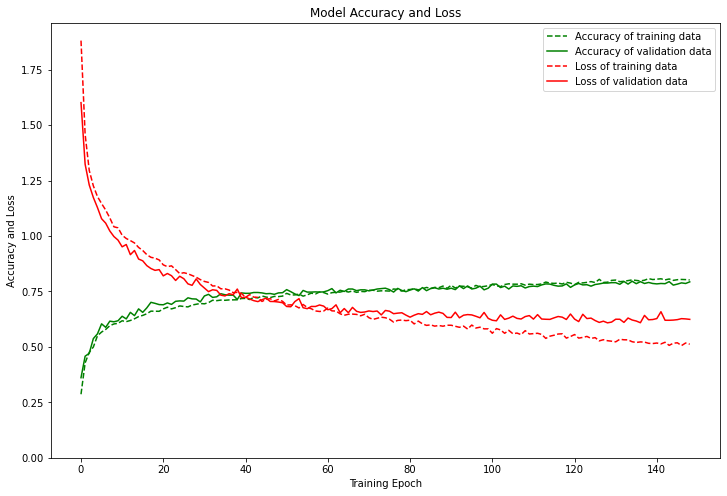

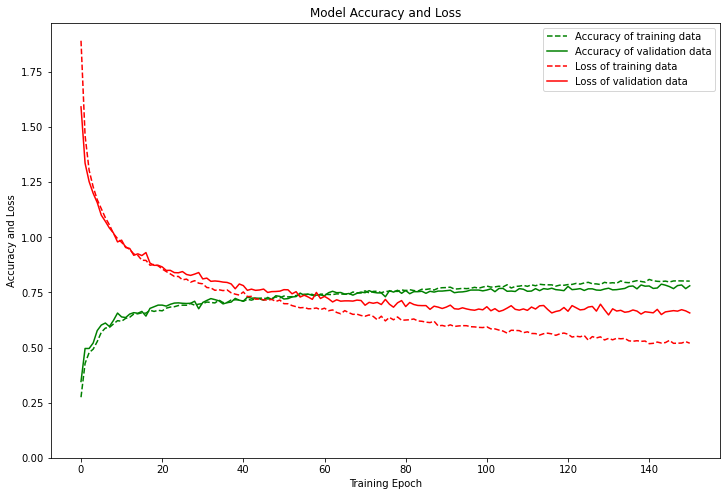

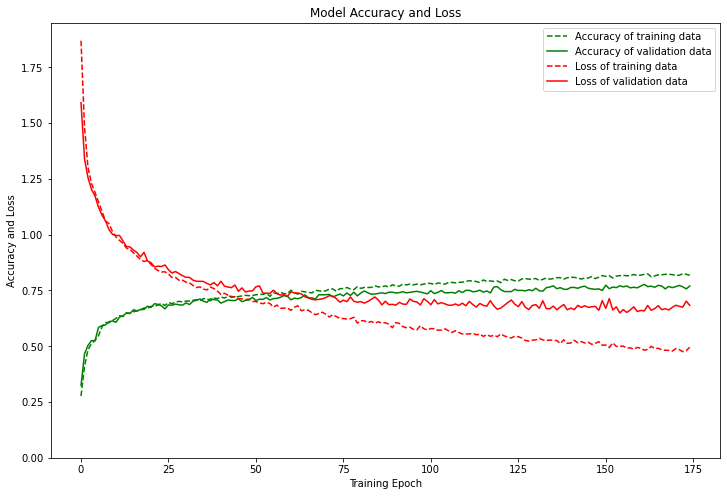

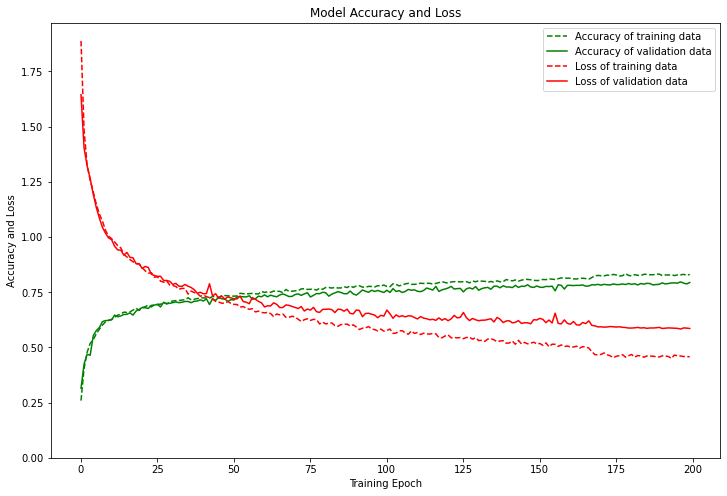

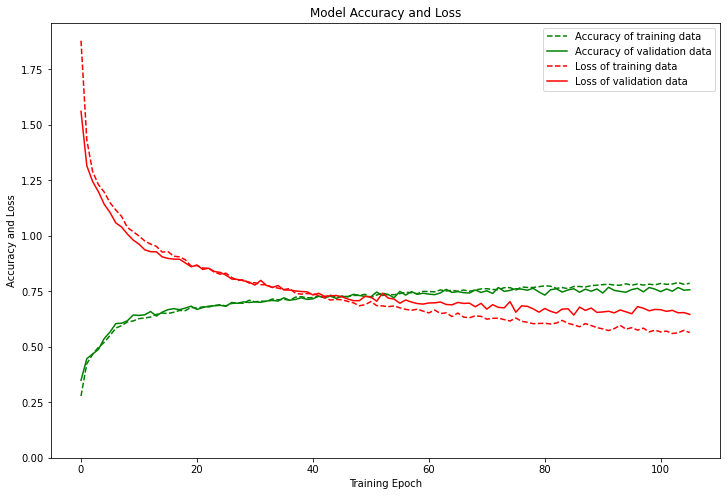

In [22]:
for history in train_histories:
    plt.figure(figsize=(12, 8))
    plt.plot(history['accuracy'], "g--", label="Accuracy of training data")
    plt.plot(history['val_accuracy'], "g", label="Accuracy of validation data")
    plt.plot(history['loss'], "r--", label="Loss of training data")
    plt.plot(history['val_loss'], "r", label="Loss of validation data")
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()